In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

In [71]:
df = pd.read_csv('..\data/raw_data/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.00,3,2.50,1530,1131,3.00,0,0,...,8,1530,0,2009,0,98103,47.70,-122.35,1530,1509
21593,6600060120,2/23/2015,400000.00,4,2.50,2310,5813,2.00,0,0,...,8,2310,0,2014,0,98146,47.51,-122.36,1830,7200
21594,1523300141,6/23/2014,402101.00,2,0.75,1020,1350,2.00,0,0,...,7,1020,0,2009,0,98144,47.59,-122.30,1020,2007
21595,291310100,1/16/2015,400000.00,3,2.50,1600,2388,2.00,0,0,...,8,1600,0,2004,0,98027,47.53,-122.07,1410,1287


In [73]:
#these dataframes will be used to set up WhyLab for monitoring of dataset and model for drifts and performance respectively
new_df_1 = df.sample(frac=0.95,replace=True)
new_df_2 = df.sample(frac=0.95,replace=True)
new_df_3 = df.sample(frac=0.95,replace=True)
new_df_4 = df.sample(frac=0.95,replace=True)

new_df_1.to_csv('..\data/monitoring_data/raw_monitoring_data/new_df_1.csv', index=False)
new_df_2.to_csv('..\data/monitoring_data/raw_monitoring_data/new_df_2.csv', index=False)
new_df_3.to_csv('..\data/monitoring_data/raw_monitoring_data/new_df_3.csv', index=False)
new_df_4.to_csv('..\data/monitoring_data/raw_monitoring_data/new_df_4.csv', index=False)

# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
#no missing data in the dataset
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [7]:
# Descriptive statistics for the numeric column
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,7.800000e+04,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.373200e+00,9.262989e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.115826e+00,7.689843e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080322e+03,9.181061e+02,3.700000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.494096e+00,5.396828e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21597.0,7.547345e-03,8.654900e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21597.0,2.342918e-01,7.663898e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21597.0,3.409825e+00,6.505456e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [8]:
#correlation of each of the predictors with the target variable
df.corr()['price']

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
waterfront       0.266398
view             0.397370
condition        0.036056
grade            0.667951
sqft_above       0.605368
sqft_basement    0.323799
yr_built         0.053953
yr_renovated     0.126424
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Name: price, dtype: float64

<AxesSubplot: >

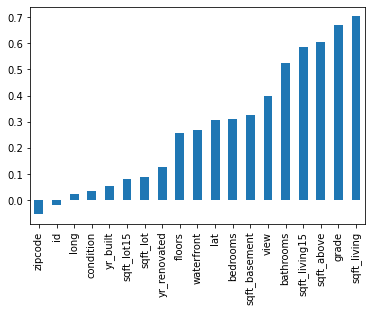

In [9]:
#visuals for correlation values
df.corr()['price'].sort_values().drop('price').plot(kind='bar')

<AxesSubplot: xlabel='price', ylabel='sqft_living'>

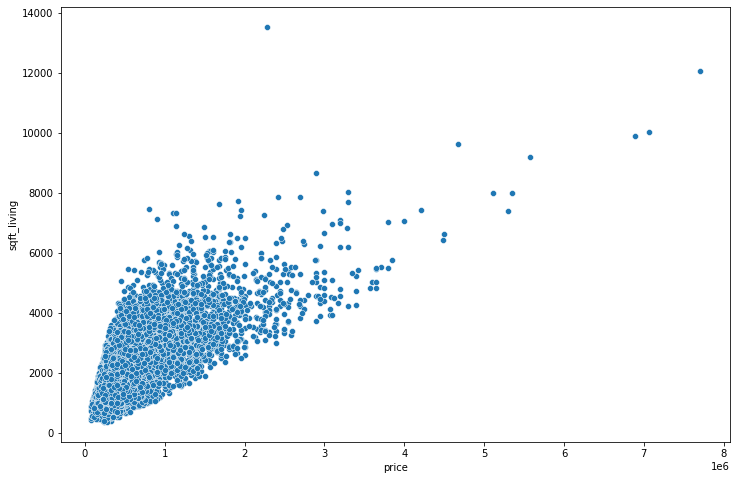

In [10]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='sqft_living',data=df)

<AxesSubplot: xlabel='grade', ylabel='price'>

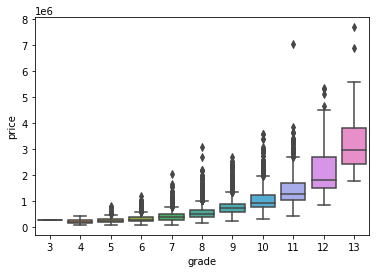

In [11]:
#The price conspicousely increase with the grade
sns.boxplot(x='grade',y='price',data=df)

<AxesSubplot: xlabel='price', ylabel='sqft_above'>

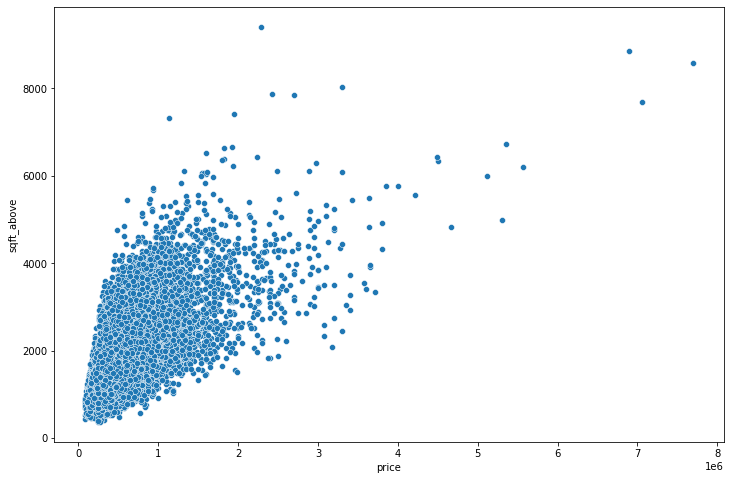

In [12]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='sqft_above',data=df)

<AxesSubplot: xlabel='bathrooms', ylabel='price'>

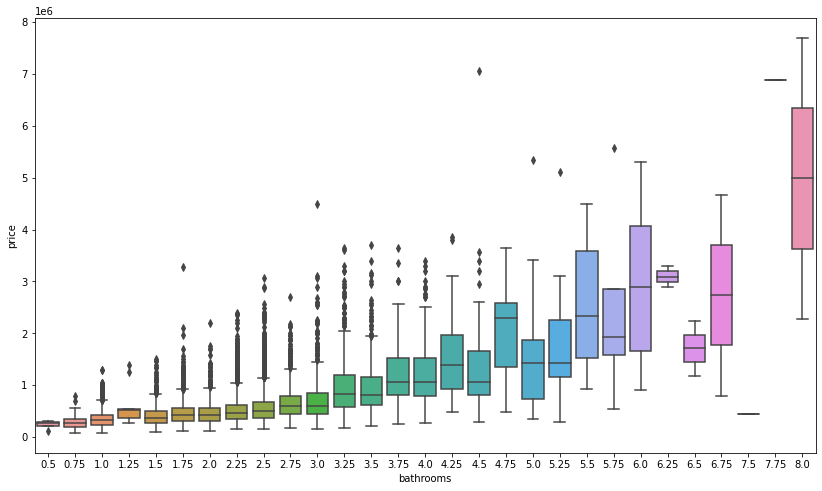

In [13]:
plt.figure(figsize=(14,8))
sns.boxplot(x='bathrooms',y='price',data=df)

In [14]:
df['bathrooms']

0        1.00
1        2.25
2        1.00
3        3.00
4        2.00
         ... 
21592    2.50
21593    2.50
21594    0.75
21595    2.50
21596    0.75
Name: bathrooms, Length: 21597, dtype: float64

<AxesSubplot: xlabel='bathrooms', ylabel='price'>

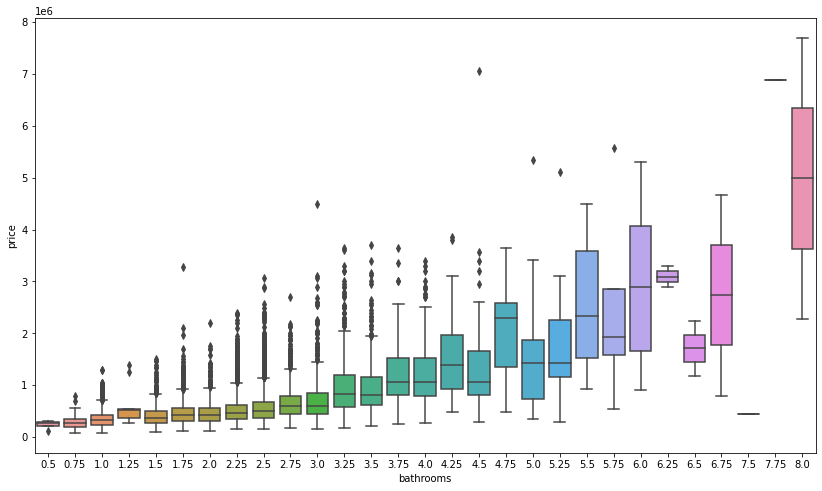

In [15]:
plt.figure(figsize=(14,8))
sns.boxplot(x='bathrooms',y='price',data=df)

<AxesSubplot: xlabel='view', ylabel='price'>

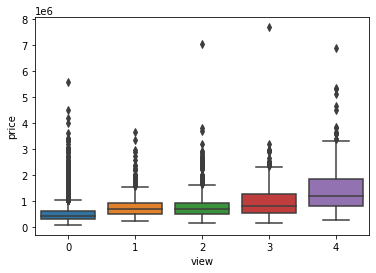

In [16]:
sns.boxplot(x='view',y='price',data=df)

<AxesSubplot: xlabel='bedrooms', ylabel='price'>

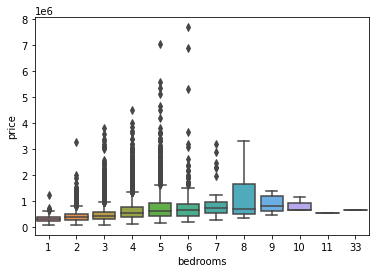

In [17]:
sns.boxplot(x='bedrooms',y='price',data=df)

<AxesSubplot: xlabel='price', ylabel='lat'>

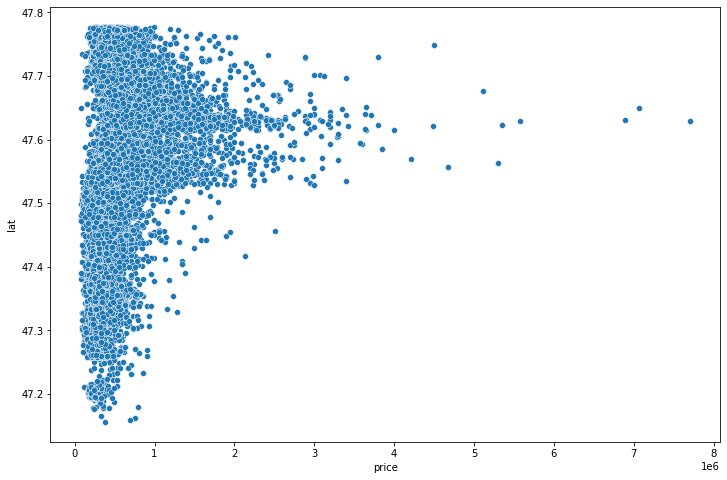

In [18]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='lat',data=df)

<AxesSubplot: xlabel='price', ylabel='long'>

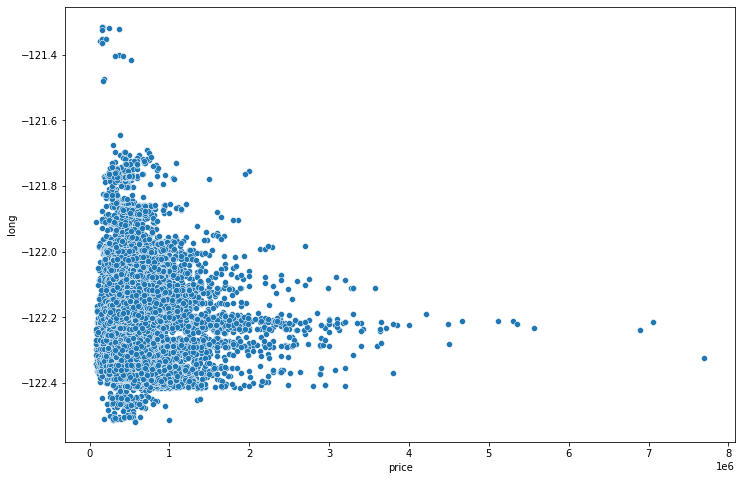

In [19]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='long',data=df)

<AxesSubplot: xlabel='long', ylabel='lat'>

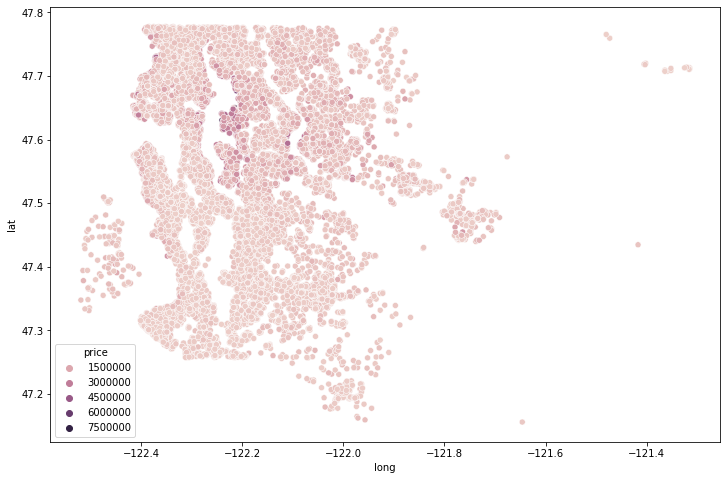

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='long',y='lat',data=df,hue='price')

<AxesSubplot: xlabel='waterfront', ylabel='price'>

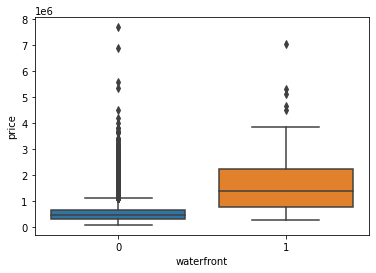

In [21]:
sns.boxplot(x='waterfront',y='price',data=df)

<AxesSubplot: xlabel='floors', ylabel='price'>

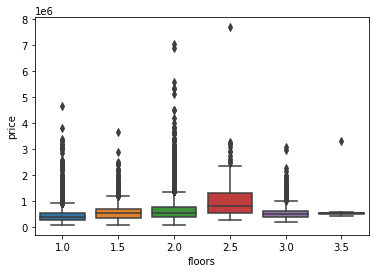

In [22]:
sns.boxplot(x='floors',y='price',data=df)

In [23]:
df_corr = df[['sqft_living','grade','sqft_above','sqft_living15','bathrooms','view','sqft_basement','bedrooms','waterfront']]
df_corr.head()

,sqft_living,grade,sqft_above,sqft_living15,bathrooms,view,sqft_basement,bedrooms,waterfront
0,1180,7,1180,1340,1.00,0,0,3,0
1,2570,7,2170,1690,2.25,0,400,3,0
2,770,6,770,2720,1.00,0,0,2,0
3,1960,7,1050,1360,3.00,0,910,4,0
4,1680,8,1680,1800,2.00,0,0,3,0


(10.0, 0.0)

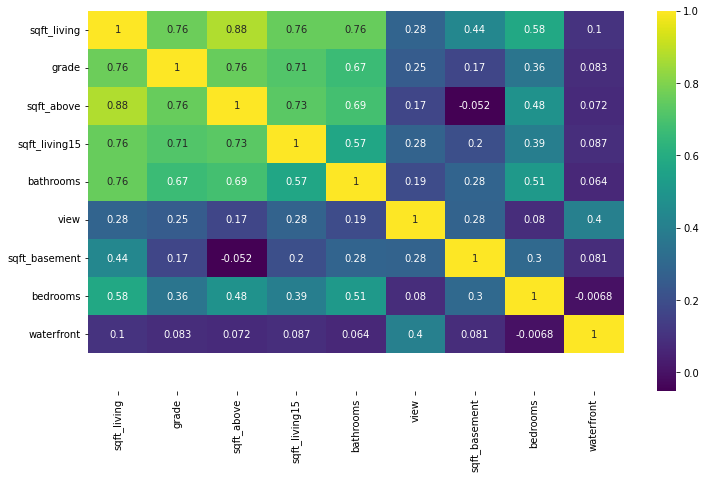

In [24]:
plt.figure(figsize=(12,7))
sns.heatmap(df_corr.corr(),annot=True,cmap='viridis')
plt.ylim(10, 0)

C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_11068\1820473487.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

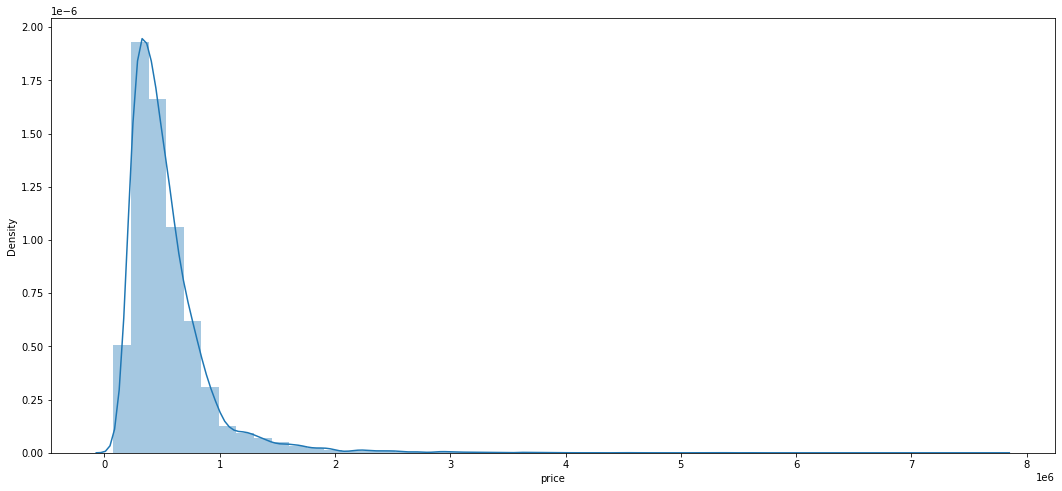

In [25]:
plt.figure(figsize=(18,8))
sns.distplot(df['price'])

# FEATURE ENGINEERING

In [26]:
df['date']

0        10/13/2014
1         12/9/2014
2         2/25/2015
3         12/9/2014
4         2/18/2015
            ...    
21592     5/21/2014
21593     2/23/2015
21594     6/23/2014
21595     1/16/2015
21596    10/15/2014
Name: date, Length: 21597, dtype: object

In [27]:
df['date'] = pd.to_datetime(df['date'])

In [28]:
df['month'] = df['date'].apply(lambda date:date.month)

In [29]:
df['year'] = df['date'].apply(lambda date:date.year)

<AxesSubplot: xlabel='year', ylabel='price'>

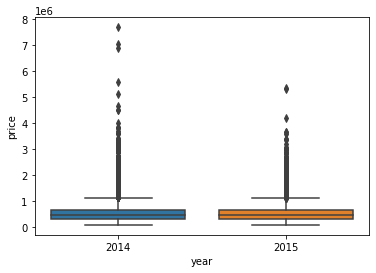

In [30]:
sns.boxplot(x='year',y='price',data=df)

<AxesSubplot: xlabel='month', ylabel='price'>

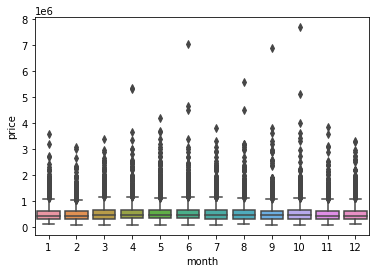

In [31]:
sns.boxplot(x='month',y='price',data=df)

<AxesSubplot: xlabel='month'>

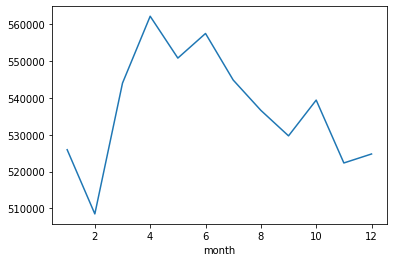

In [32]:
df.groupby('month').mean()['price'].plot()

<AxesSubplot: xlabel='year'>

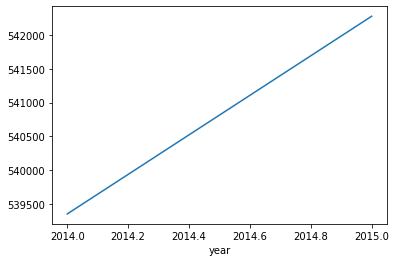

In [33]:
df.groupby('year').mean()['price'].plot()

In [34]:
df = df.drop('date',axis=1)

In [35]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'year'],
      dtype='object')

In [36]:
#id is just unique identifier and has no relationship with price, as confirmed by the correlation value
df = df.drop('id',axis=1)

In [37]:
df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [38]:
df['zipcode'].nunique()

70

In [39]:
df = df.drop('zipcode', axis=1)

In [40]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month,year
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,10,2014
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,12,2014
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,2,2015
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,12,2014
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,2,2015


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month 

# TRAIN TEST SPLIT

In [42]:
from sklearn.model_selection import train_test_split
X = df.drop('price',axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=43)

# MODEL TRAINING

In [43]:
#from lazypredict.Supervised import LazyRegressor

In [44]:
# fit all models
#clf = LazyRegressor(predictions=True)
#models, predictions = clf.fit(X_train, X_test, y_train, y_test)

In [58]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
# set up our search grid
param_grid = {"max_depth":    [5, 6,7],
              "n_estimators": [600, 700, 800],
              "learning_rate": [0.01, 0.015, 0.020]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 800}


In [59]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

# MODEL EVALUATION

In [65]:
predictions = regressor.predict(X_test)
RMSLE = np.sqrt(MSE(y_test, predictions))
print("The score is %f" % RMSLE )

The score is 119867.677393


In [67]:
from sklearn.metrics import r2_score
R_Squared = r2_score(y_test, predictions)
print("The score is %f" % R_Squared )

The score is 0.894498


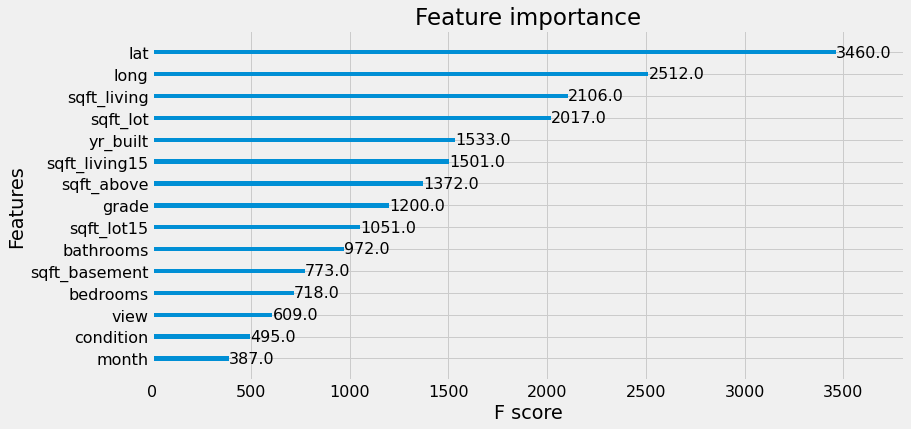

In [64]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=15, ax=ax)
plt.show();